## Self Attention Model
\begin{align}
Q &= X W^Q, \\
K &= X W^K, \\
V &= X W^V, \\
\text{Attention}(Q, K, V) 
  &= \operatorname{Softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V.
\end{align}

\begin{align}
\text{MultiHead}(X) 
  &= \text{Concat}\big(\text{head}_1, \ldots, \text{head}_h\big) W^O, \\
\text{head}_i 
  &= \operatorname{Attention}(X W_i^Q, X W_i^K, X W_i^V).
\end{align}


In [1]:
import torch
import torch.nn as nn
class myselfattention(nn.Module):
    def __init__(self, d_in, d_out,context_length,bias=True):
        super().__init__()
        self.W_value=nn.Linear(d_in,d_out,bias=bias)
        self.W_query=nn.Linear(d_in,d_out,bias=bias)
        self.W_key=nn.Linear(d_in,d_out,bias=bias)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New
    def forward(self, x): 
        _,num_tokens,_=x.shape
        value=self.W_value(x)
        query=self.W_query(x)
        key=self.W_key(x)
        attn_scores=query@key.mT
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)      
        return nn.Softmax(dim=-1)(attn_scores/key.shape[-1]**0.5)@value
myattention=myselfattention(4,4,3)
input=torch.rand(2,3,4)
output=myattention(input)
print(f"output size is: {output.shape}")

output size is: torch.Size([2, 3, 4])


In [2]:
class myselfattention_mh(nn.Module):
    def __init__(self, d_in, d_head, d_out,context_length,bias=True):
        super().__init__()
        self.heads=nn.ModuleList([myselfattention(d_in, d_out//d_head, context_length) for _ in range(d_head)])
        self.W_out=nn.Linear(d_out,d_out,bias)
    def forward(self, x): 
        out=torch.cat([self.heads[i](x) for i in range(len(self.heads))], dim=-1)
        return self.W_out(out)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(myselfattention_mh(16,8,16,7))

1088

In [4]:
class mySilu(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x): 
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+0.044715*x**3)))

In [5]:
class ffn(nn.Module):
    def __init__(self,dim,dropout=0.1,bias=True):
        super().__init__()
        self.W1=nn.Linear(dim,4*dim,bias)
        self.W2=nn.Linear(4*dim,dim,bias)
        self.dropout=nn.Dropout(dropout)
        self.silu=mySilu()
    def forward(self, x): 
        return self.dropout(self.W2(self.silu(self.W1(x))))

In [6]:
class myTransformer(nn.Module):
    def __init__(self, heads, dropout, hidden,context_length,bias=True):
        super().__init__()
        self.myselfattention_mh=myselfattention_mh(hidden,heads,hidden,context_length)#nn.ModuleList([myselfattention(d_in, d_head) for _ in range(d_out//d_head)])
        self.layernorm1=nn.LayerNorm(hidden)
        self.layernorm2=nn.LayerNorm(hidden)
        self.ffn=ffn(hidden,dropout,bias)
        self.dropout=dropout
    def forward(self, x): 
        shortcut1=x;
        x=self.layernorm1(x)
        x=self.myselfattention_mh(x)
        x=nn.Dropout(self.dropout)(x)
        x=x+shortcut1
        shortcut2=x;
        x=self.layernorm2(x)
        x=self.ffn(x)
        x=nn.Dropout(self.dropout)(x)
        x=x+shortcut2
        return x

In [7]:
cfg={
    "layers": 12,
    "heads": 12,
    "dropout": 0.1,
    "context_length": 1024,
    "hidden_dim": 768,
    "voc_size": 50257
}
class myGPT2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers=cfg["layers"]
        self.heads=cfg["heads"]
        self.dropout=cfg["dropout"]
        self.context_length=cfg["context_length"]
        self.hidden_dim=cfg["hidden_dim"]
        self.voc_size=cfg["voc_size"]
        self.wte=nn.Embedding(self.voc_size,self.hidden_dim)
        self.wpe=nn.Embedding(self.context_length,self.hidden_dim)
        self.layernorm=nn.LayerNorm(self.hidden_dim)
        self.linear=nn.Linear(self.hidden_dim,self.voc_size,bias=False)
        self.transformerBlocks=nn.ModuleList([myTransformer(self.heads,self.dropout,self.hidden_dim,self.context_length) for _ in range(self.layers)])
    def forward(self, x): 
        batch,length=x.shape
        te=self.wte(x);
        pe=self.wpe(torch.arange(length, device=x.device));
        x=te+pe;
        x=nn.Dropout(self.dropout)(x)
        x=nn.Sequential(*self.transformerBlocks)(x)
        x=self.layernorm(x)
        x=self.linear(x)
        return x

In [8]:
x=torch.tensor([[1, 2, 3], [4, 5, 6]])
model=myGPT2(cfg)
model(x).shape

torch.Size([2, 3, 50257])

In [9]:
count_parameters(model)

163037184

In [10]:
input_text1="I study at Clemson"
input_text2="I am a student"
input = [input_text1,input_text2]
import tiktoken

# Load GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")

##TODO: how to get the tokens of input
tokens = [enc.encode(text) for text in input]


/home/kail/.conda/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [11]:
tokens

[[40, 2050, 379, 27801], [40, 716, 257, 3710]]

In [12]:
model(torch.tensor(tokens)).shape

torch.Size([2, 4, 50257])

In [13]:
def generate(model,tokens,max_length):
    for i in range(max_length):
        with torch.no_grad():
            x=model(tokens)
        ##TODO: return the generation with max_length limit
        logits=x[:,-1,:]
        _,idx=torch.max(logits, dim=-1, keepdim=True)
        tokens=torch.cat((tokens, idx), dim=1)
    return tokens
generated=generate(model,torch.tensor(tokens),6)

In [14]:
generated

tensor([[   40,  2050,   379, 27801, 27625, 26667, 48699,  8230, 12614, 46422],
        [   40,   716,   257,  3710, 35418, 27448,  1461, 48983,  3909, 43458]])

In [15]:
for i, seq in enumerate(generated.tolist()):
    text = enc.decode(seq)
    print(f"Sequence {i}: {text}")

Sequence 0: I study at Clemsononian pedalorescencequartersoples outfielder
Sequence 1: I am a student Sheepibling pop Timberwolves Saturday fs


In [16]:
enc.encode(text)

[40, 716, 257, 3710, 35418, 27448, 1461, 48983, 3909, 43458]

In [17]:
import os
import requests

In [18]:
file_path = "small.txt"
with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [19]:
print(text_data[:99])

﻿The Project Gutenberg eBook of Two Centuries of Costume in America, Vol. 1 (1620-1820), by Alice M


In [20]:
print(text_data[-99:])

help produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.


In [21]:
total_characters = len(text_data)
total_tokens = len(enc.encode(text_data,disallowed_special=()))


print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 527230
Tokens: 140584


In [22]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=True,
    shuffle=True,
    #num_workers=2
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=False,
    shuffle=False,
    #num_workers=2
)

In [23]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    break

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    break

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])

Validation loader:
torch.Size([2, 1024]) torch.Size([2, 1024])


In [24]:
x[0,:10]

tensor([3856, 1000,  468,  530,   26,  475,  198, 4480,  262, 1049])

In [25]:
y[0,:10]

tensor([1000,  468,  530,   26,  475,  198, 4480,  262, 1049, 2478])

This makes sense as we discussed in class that the output response is just 1 stride increase of the input.

In [26]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 124928
Validation tokens: 13312
All tokens: 138240


In [27]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    prediction=model(input_batch)
    return torch.nn.functional.cross_entropy(prediction.flatten(0, 1), target_batch.flatten())
    ##TODO: calculate batch loss

In [28]:
def calc_loss_loader(data_loader, model, device,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            total_loss += calc_loss_batch(input_batch, target_batch, model, device).item()
            ##TODO: calculate total_loss which will call function calc_loss_batch defined above
        else:
            break
    return total_loss / num_batches

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
torch.manual_seed(123) 
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.989176890889151
Validation loss: 10.97281891959054


In [30]:
from previous_chapters import generate_text_simple
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.wpe.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [31]:
import time
start_time = time.time()

torch.manual_seed(123)
model = myGPT2(cfg)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 4
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=enc
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.876, Val loss 9.827
Ep 1 (Step 000005): Train loss 8.321, Val loss 8.392
Ep 1 (Step 000010): Train loss 7.414, Val loss 7.620
Ep 1 (Step 000015): Train loss 7.083, Val loss 7.391
Ep 1 (Step 000020): Train loss 7.104, Val loss 7.377
Ep 1 (Step 000025): Train loss 6.838, Val loss 7.341
Ep 1 (Step 000030): Train loss 6.971, Val loss 7.145
Ep 1 (Step 000035): Train loss 6.650, Val loss 7.101
Ep 1 (Step 000040): Train loss 6.685, Val loss 6.991
Ep 1 (Step 000045): Train loss 6.557, Val loss 6.941
Ep 1 (Step 000050): Train loss 6.470, Val loss 6.871
Ep 1 (Step 000055): Train loss 6.355, Val loss 6.833
Ep 1 (Step 000060): Train loss 6.375, Val loss 6.782
Every effort moves you                                                  
Ep 2 (Step 000065): Train loss 6.426, Val loss 6.762
Ep 2 (Step 000070): Train loss 6.351, Val loss 6.749
Ep 2 (Step 000075): Train loss 6.228, Val loss 6.729
Ep 2 (Step 000080): Train loss 6.257, Val loss 6.758
Ep 2 (Step 000085): Train 

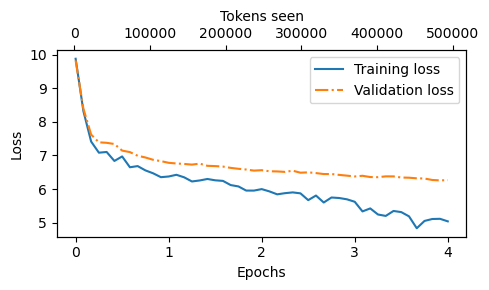

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [33]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [34]:
torch.manual_seed(123)
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", enc).to(inference_device),
    max_new_tokens=15,
    context_size=cfg["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, enc))

Output text:
 Every effort moves you-s, “Hman. For some his own
And a


In [35]:
from gpt_download import download_and_load_gpt2

2025-10-30 14:38:42.265340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [37]:
print(list(params.keys()))

['blocks', 'b', 'g', 'wpe', 'wte']


In [38]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [39]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.wpe.weight = assign(gpt.wpe.weight, params['wpe'])
    gpt.wte.weight = assign(gpt.wte.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        # print(f"q_w size is: {q_w.shape}")
        # print(f"k_w size is: {k_w.shape}")
        # print(f"v_w size is: {v_w.shape}")
        for h in range(cfg["heads"]):
            # print(f"{gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.weight.shape}")
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.weight = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.weight, torch.chunk(torch.tensor(q_w.T), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.weight = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.weight, torch.chunk(torch.tensor(k_w.T), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.weight = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.weight, torch.chunk(torch.tensor(v_w.T), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.bias = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.bias, torch.chunk(torch.tensor(q_b), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.bias = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.bias, torch.chunk(torch.tensor(k_b), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.bias = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.bias, torch.chunk(torch.tensor(v_b), cfg["heads"], dim=0)[h])
            
        
        #print(f"q_b size is: {q_b.shape}")
        

        gpt.transformerBlocks[b].myselfattention_mh.W_out.weight = assign(
            gpt.transformerBlocks[b].myselfattention_mh.W_out.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformerBlocks[b].myselfattention_mh.W_out.bias = assign(
            gpt.transformerBlocks[b].myselfattention_mh.W_out.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformerBlocks[b].ffn.W1.weight = assign(
            gpt.transformerBlocks[b].ffn.W1.weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformerBlocks[b].ffn.W1.bias = assign(
            gpt.transformerBlocks[b].ffn.W1.bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        # gpt.trf_blocks[b].ff.layers[0].bias = assign(
        #     gpt.trf_blocks[b].ff.layers[0].bias, 
        #     params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformerBlocks[b].ffn.W2.weight = assign(
            gpt.transformerBlocks[b].ffn.W2.weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformerBlocks[b].ffn.W2.bias = assign(
            gpt.transformerBlocks[b].ffn.W2.bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        # gpt.trf_blocks[b].ff.layers[2].bias = assign(
        #     gpt.trf_blocks[b].ff.layers[2].bias, 
        #     params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformerBlocks[b].layernorm1.weight = assign(
            gpt.transformerBlocks[b].layernorm1.weight, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformerBlocks[b].layernorm1.bias = assign(
            gpt.transformerBlocks[b].layernorm1.bias, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformerBlocks[b].layernorm2.weight = assign(
            gpt.transformerBlocks[b].layernorm1.weight, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformerBlocks[b].layernorm2.bias = assign(
            gpt.transformerBlocks[b].layernorm1.bias, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.layernorm.weight = assign(gpt.layernorm.weight, params["g"])
    gpt.layernorm.bias = assign(gpt.layernorm.bias, params["b"])
    gpt.linear.weight = assign(gpt.linear.weight, params["wte"])
    
    
load_weights_into_gpt(model, params)
model.to(device);
model.eval();

/local_scratch/slurm.6734338/ipykernel_1557032/1629613674.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.nn.Parameter(torch.tensor(right))


In [40]:
torch.manual_seed(12345)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", enc).to(device),
    max_new_tokens=25,
    context_size=cfg["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, enc))

Output text:
 Every effort moves you towards yourself. As an adult, one of your first jobs must be in some way of life: to survive and care for


In [41]:
import os
from pathlib import Path
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [42]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [43]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})    

In [44]:
balanced_df

Label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
...     ...                                                ...
5537      1  Want explicit SEX in 30 secs? Ring 02073162414...
5540      1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547      1  Had your contract mobile 11 Mnths? Latest Moto...
5566      1  REMINDER FROM O2: To get 2.50 pounds free call...
5567      1  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]

In [45]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [46]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [47]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [48]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [49]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [50]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [51]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [52]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [53]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
device = torch.device("cpu")
model.to(device) 
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=cfg["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [54]:
print(model)

myGPT2(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=768, out_features=50257, bias=False)
  (transformerBlocks): ModuleList(
    (0-11): 12 x myTransformer(
      (myselfattention_mh): myselfattention_mh(
        (heads): ModuleList(
          (0-11): 12 x myselfattention(
            (W_value): Linear(in_features=768, out_features=64, bias=True)
            (W_query): Linear(in_features=768, out_features=64, bias=True)
            (W_key): Linear(in_features=768, out_features=64, bias=True)
          )
        )
        (W_out): Linear(in_features=768, out_features=768, bias=True)
      )
      (layernorm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ffn): ffn(
        (W1): Linear(in_features=768, out_features=3072, bias=True)
        (W2): Linear(in_features=3072, out_features=7

In [55]:
##TODO: we first freeze the model, meaning that we make all layers non-trainable
for param in model.parameters():
    param.requires_grad = False

In [56]:
##TODO: change the last linear layer as we only have 2 classes
model.linear=nn.Linear(cfg["hidden_dim"],2)

In [57]:
for param in model.transformerBlocks[-1].parameters():
    param.requires_grad = True
for param in model.layernorm.parameters():
    param.requires_grad = True    
##TODO: we are also make the last transformer block and the final LayerNorm module connectingthe last transformer block to the output layer trainable

In [58]:
count_parameters(model)
##TODO: now calculate how many trainable parameters in the model manually and compare by writing a code snippet

7090946

In [59]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [60]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-2.0356, -1.2948],
         [-9.2545, -6.7965],
         [-6.5557, -6.5859],
         [-4.0350, -4.9194]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [61]:
##TODO: write a code snippet to determine the label
probs=torch.softmax(outputs[:,-1,:],dim=-1)
print(f"Class label: {torch.argmax(probs, dim=-1).item()}")

Class label: 0


In [62]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits=model(input_batch)[:,-1,:]
                ##TODO: output the logits for further use to determine class labels
                
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 55.00%
Test accuracy: 46.25%


In [64]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    ##TODO: output the logits
    logits = model(input_batch)[:,-1,:]
    ##TODO: output the loss
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [65]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [66]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.760
Validation loss: 0.931
Test loss: 0.932


In [67]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [68]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [69]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.847, Val loss 0.867
Ep 1 (Step 000050): Train loss 0.737, Val loss 0.706
Ep 1 (Step 000100): Train loss 0.631, Val loss 0.634
Training accuracy: 50.00% | Validation accuracy: 57.50%
Ep 2 (Step 000150): Train loss 0.637, Val loss 0.641
Ep 2 (Step 000200): Train loss 0.587, Val loss 0.599
Ep 2 (Step 000250): Train loss 0.506, Val loss 0.531
Training accuracy: 67.50% | Validation accuracy: 77.50%
Ep 3 (Step 000300): Train loss 0.406, Val loss 0.512
Ep 3 (Step 000350): Train loss 0.376, Val loss 0.459
Training accuracy: 85.00% | Validation accuracy: 87.50%
Ep 4 (Step 000400): Train loss 0.264, Val loss 0.362
Ep 4 (Step 000450): Train loss 0.468, Val loss 0.419
Ep 4 (Step 000500): Train loss 0.361, Val loss 0.379
Training accuracy: 90.00% | Validation accuracy: 80.00%
Ep 5 (Step 000550): Train loss 0.476, Val loss 0.414
Ep 5 (Step 000600): Train loss 0.512, Val loss 0.341
Training accuracy: 87.50% | Validation accuracy: 82.50%
Ep 6 (Step 000650): Train loss 

In [70]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

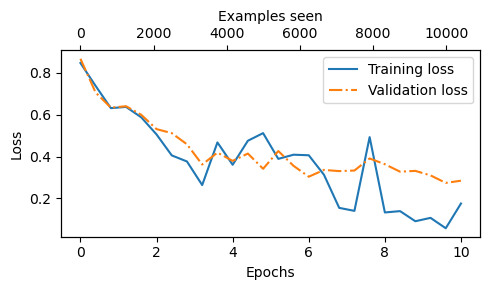

In [71]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [72]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 93.94%
Validation accuracy: 91.95%
Test accuracy: 94.33%


In [73]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.wpe.weight.shape[0]
    
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )    
    
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        ##output logits
        logits=model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [74]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [75]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [76]:
torch.save(model.state_dict(), "review_classifier.pth")
# For a new session, we could load the model as follows
# model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
# model.load_state_dict(model_state_dict)

In [77]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [78]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text,
    SpamDataset
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [79]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [80]:
torch.manual_seed(123)

num_classes = 2
model.out_head=nn.Linear(768,2)
##TODO: change the last layer for 2 classes

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [82]:
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [83]:
from previous_chapters import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [84]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))  # similar to standard weight initialization
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
        self.rank = rank

    def forward(self, x):
        
        x = (self.alpha / self.rank) * (x@self.A@self.B)##TODO: complete the output for lora
        return x

In [85]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(self.linear.in_features, self.linear.out_features, rank, alpha
            ##TODO: initialize the layer
        )

    def forward(self, x):
        return self.linear(x)+self.lora(x)##TODO: define the output

In [86]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha)

In [87]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [88]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


In [89]:
##TODO: verify the number manually

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [91]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [92]:
import time
from previous_chapters import train_classifier_simple

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.346, Val loss 0.325
Ep 1 (Step 000100): Train loss 0.063, Val loss 0.144
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.054, Val loss 0.045
Ep 2 (Step 000200): Train loss 0.058, Val loss 0.122
Ep 2 (Step 000250): Train loss 0.041, Val loss 0.199
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.020, Val loss 0.153
Ep 3 (Step 000350): Train loss 0.017, Val loss 0.186
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.017, Val loss 0.094
Ep 4 (Step 000450): Train loss 0.001, Val loss 0.148
Ep 4 (Step 000500): Train loss 0.096, Val loss 0.253
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.038, Val loss 0.408
Ep 5 (Step 000600): Train loss 0.005, Val loss 0.123
Training accuracy: 100.00% | Validation accuracy: 95.00%
Training completed in 1.38

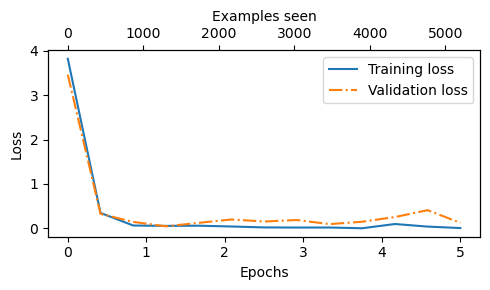

In [93]:
from previous_chapters import plot_values
# Alternatively:
# from llms_from_scratch.ch06 import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [94]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.90%
Validation accuracy: 97.32%
Test accuracy: 97.00%
